### YOLOv5 installation
NB! Meant to be run in Google Colab.

### As long as you change the *path_to_project* variable to your path up until the project and *project_root* NATO-Symbols part to the project folder name, code should run seamlessly.

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print("Probably not using Colab, skipping...")

Mounted at /content/drive


In [2]:
path_to_project=input("Path to project root folder? For default (/content/drive/MyDrive/Yolov5), leave empty")

Path to project root folder? For default (/content/drive/MyDrive/Yolov5), leave empty


In [3]:
!cd /content
import os

if not path_to_project:
  path_to_project="/content/drive/MyDrive/Yolov5"# /home/erkoiv/Desktop
project_root=path_to_project+"/NATO-Symbols"
yolo_dir=project_root+"/yolov5"
#NOTE THAT YOLO EXPECTS THE datasets FOLDER TO BE IN THE SAME ROOT FOLDER AS IT IS
img_dir=project_root+"/datasets/NATO-Symbols/images"
label_dir=project_root+"/datasets/NATO-Symbols/labels"
if yolo_dir==None:
  yolo_dir=input("Please paste the directory you want to install YOLOv5 into. WITHOUT / IN THE END")

%cd {project_root}

![ -d {yolo_dir} ] && echo "YOLO DIRECTORY EXISTS SKIPPING INSTALL"
![ ! -d {yolo_dir} ] && echo "INSTALLING YOLOv5 INTO DESIGNATED DIRECTORY" && git clone https://github.com/ultralytics/yolov5


/content/drive/MyDrive/Yolov5/NATO-Symbols
YOLO DIRECTORY EXISTS SKIPPING INSTALL


### Requirements installation
NB! Meant to be run in Google Colab.

In [4]:
import sys
if project_root+"/scripts" not in sys.path:
  sys.path.append(project_root+"/scripts")
yolo_reqs=yolo_dir+"/requirements.txt"
project_reqs=project_root+"/requirements.txt"
!python3 -m pip install wandb==0.12.10
!python3 -m pip install -r  {yolo_reqs}
!python3 -m pip install -r {project_reqs}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 31.2 MB/s 
     |████████████████████████████████| 181 kB 73.8 MB/s 
     |████████████████████████████████| 145 kB 62.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=38ea630af6e67b26429bf9b63c1f25840e530f65cd0d54199d4a2c7b133fe089
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 33.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/col

In [5]:
#!cp /content/drive/MyDrive/Yolov5/NATO-Symbols/scripts/augment_tools.py /content #THIS IS ONLY NEEDED IF YOU OTHERWISE GET AN IMPORT ERROR

### Generate a YOLOv5 dataset

This is based on single-symbol images that will be randomly placed on a white canvas to compose a set of multi-symbol images that will be used in training the YOLOv5 weights.

In [12]:
import numpy as np
import cv2
from random import randint
from scipy import ndimage
import os
import re
from tqdm import tqdm
from augment_tools import augment
from matplotlib import pylab as plt
try:
  from google.colab.patches import cv2_imshow
except:
  pass


clean=False
dataset_sz=500
dim=(720,1280)
label_list=["advance_to_contact", "attack", "block", "counterattack", "cover", "delay", "destroy", "disrupt", "guard", "occupy", "retain", "screen", "secure", "seize", "support_by_fire"]
localize_list=["symbol"]
try: 
  crawl_folders=input("Which folders should I crawl in datasets folder for symbols, separated by ', '? Leave empty for default (raw-clean, raw)").split(", ")
except:
  print("Issue getting symbol folders")

if len(crawl_folders[0])<1:
  crawl_folders=[]
  print("Using default crawled folders...")
  crawl_folders.append("raw-clean")
  crawl_folders.append("raw")

Which folders should I crawl in datasets folder for symbols, separated by ', '? Leave empty for default (raw-clean, raw)
Using default crawled folders...


FINAL IMAGE FROM CHECKED FOLDER:



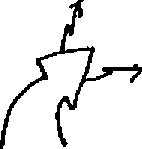

Checking subdirectory  /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw/mihkell
FINAL IMAGE FROM CHECKED FOLDER:



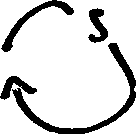

Checking subdirectory  /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw/mihkell2
FINAL IMAGE FROM CHECKED FOLDER:



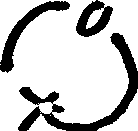

Checking subdirectory  /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw/cadet_drawings
FINAL IMAGE FROM CHECKED FOLDER:



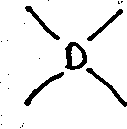

There are 16 unique labels: 
['advance_to_contact' 'attack' 'block' 'counterattack'
 'counterattack_by_fire' 'cover' 'delay' 'destroy' 'disrupt' 'guard'
 'occupy' 'retain' 'screen' 'secure' 'seize' 'support_by_fire']
 among 458 crawled symbols


In [ ]:
raws=[]
raw_labels=[]
symbol_dirs=[]
total_syms=0
datasets_root=project_root+"/datasets"
for crawl_folder in crawl_folders:
  symbol_dirs.append(datasets_root+"/"+crawl_folder)

for dir in symbol_dirs:
  insides=os.listdir(dir)
  if ".jpg" in insides[0] or ".png" in insides[0]:
    for title in insides:
      raw=cv2.imread(dir+"/"+title, cv2.IMREAD_GRAYSCALE)
      raw=cv2.resize(raw, (150,150), cv2.INTER_AREA)
      raw=cv2.adaptiveThreshold(raw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 19)

      raw=raw[np.argwhere(np.amin(raw,axis=1)<120)[0][0]:np.argwhere(np.amin(raw,axis=1)<120)[-1][0],:]
      raw = raw[:,np.argwhere(np.amin(raw,axis=0) < 120)[0][0]:np.argwhere(np.amin(raw,axis=0) < 120)[-1][0]]

      raws.append(raw)
      raw_labels.append(re.findall('([a-zA-Z_ ]*)\d*.*', title)[0])

    print("FINAL IMAGE FROM CHECKED FOLDER:\n")
    cv2_imshow(raw)
    total_syms+=len(insides)

  else:
    for subdir in insides:
      subpath=dir+"/"+subdir
      file_list=os.listdir(subpath)
      print("Checking subdirectory ", subpath)

      for title in file_list:
        #print(dir+"/"+title)
        raw=cv2.imread(subpath+"/"+title, cv2.IMREAD_GRAYSCALE)
        raw=cv2.resize(raw, (150,150), cv2.INTER_AREA)
        raw=cv2.adaptiveThreshold(raw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 19)

        raw=raw[np.argwhere(np.amin(raw,axis=1)<120)[0][0]:np.argwhere(np.amin(raw,axis=1)<120)[-1][0],:]
        raw = raw[:,np.argwhere(np.amin(raw,axis=0) < 120)[0][0]:np.argwhere(np.amin(raw,axis=0) < 120)[-1][0]]

        raws.append(raw)
        raw_labels.append(re.findall('([a-zA-Z_ ]*)\d*.*', title)[0])
      print("FINAL IMAGE FROM CHECKED FOLDER:\n")
      cv2_imshow(raw)
      total_syms+=len(insides)
print("There are {} unique labels: \n{}\n among {} crawled symbols".format(len(np.unique(raw_labels)), np.unique(raw_labels), total_syms))

In [ ]:
def generate_image(raw, raw_labels, dim=(850,850),min_sym=5,max_sym=9, max_overlap=15, bg_dim=0.85):
  canvas=np.full(dim,int(bg_dim*255))
  sym_data=[]
  locations=[]

  for i in range(randint(min_sym,max_sym)):
    choice_idx=randint(0,len(raw)-1)
    chosen=np.copy(raw[choice_idx])
    chosen=augment(chosen.astype(np.uint8), apply_resize=True, apply_flip=True, apply_rotation=True, apply_transformation=True, apply_boldness=True)

    while(True):
      overlap=False
      top_leftX=randint(0,dim[0]-chosen.shape[0])
      top_leftY=randint(0,dim[1]-chosen.shape[1])
      for j in range(len(locations)):
        if ((top_leftX < locations[j][1][0]-max_overlap) and (top_leftY < locations[j][1][1]-max_overlap) and (top_leftX+chosen.shape[0] > locations[j][0][0]+max_overlap) and (top_leftY+chosen.shape[1] > locations[j][0][1]+max_overlap)):
          overlap=True
          break
      if not overlap:
        break

    locations.append([[top_leftX,top_leftY],[top_leftX+chosen.shape[0],top_leftY+chosen.shape[1]]])
    canvas[top_leftX:(top_leftX+chosen.shape[0]),top_leftY:(top_leftY+chosen.shape[1])][chosen < 140] = chosen[chosen < 140]
    
    #YOLO xywh format, flip x and y and w and h from previous step
    dimX, dimY = dim
    y=round(((top_leftX+(chosen.shape[0]/2))/dimX),2)
    x=round(((top_leftY+(chosen.shape[1]/2))/dimY),2)
    h=round((chosen.shape[0]/dimX),2)
    w=round((chosen.shape[1]/dimY),2)

    #Class nr
    label=raw_labels[choice_idx]
    if label=="counterattack_by_fire":
      label="counterattack"
    class_nr=label_list.index(label)
    sym_data.append([class_nr, x, y, w, h])


  return canvas, sym_data

In [ ]:
if not os.path.exists(img_dir+"/train/img0.jpg"):
  trainnr=int(0.85*dataset_sz)

  for i in tqdm(range(dataset_sz)):
    img, img_data = generate_image(raws, raw_labels, dim)

    if i<trainnr:
      if cv2.imwrite(img_dir+"/train/img"+str(i)+".jpg", img):
        with open(label_dir+"/train/img"+str(i)+".txt", 'w') as f:
          for j in img_data:
            for k in j:
              f.write(str(k)+" ")
            f.write("\n")
    else:
      if cv2.imwrite(img_dir+"/val/img"+str(i)+".jpg", img):
        with open(label_dir+"/val/img"+str(i)+".txt", 'w') as f:
          for j in img_data:
            for k in j:
              f.write(str(k)+" ")
            f.write("\n")


### Training YOLOv5

In [6]:
import wandb
train_dir=yolo_dir+"/train.py"
detect_dir=yolo_dir+"/detect.py"

In [7]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
run_id = input("What is the name of the run? Be descriptive. Example 5l-300-colabGPU. ") #5l-300-colabGPU
if not run_id:
  run_id = "unnamed"
!python3 {train_dir} --img 640 --batch 24 --epochs 300 --data NATO-Symbols.yaml --weights yolov5m.pt --project NATO-Symbols-Log --name {run_id} --cache

What is the name of the run? Be descriptive. Example 5l-300-colabGPU. 5m-300-colabGPU
wandb: Currently logged in as: erkoiv (use `wandb login --relogin` to force relogin)
train: weights=yolov5m.pt, cfg=, data=NATO-Symbols.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=24, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=NATO-Symbols-Log, name=5m-300-colabGPU, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
YOLOv5 🚀 v6.1-211-gcee5959 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01029, lrf=0.01204, mom

# Detection

Test the best achieved weights on a set of images.

In [28]:
run_id = input("Typer the name of the run log from which you want to use the best weights")

Typer the name of the run log from which you want to use the best weights5m-300-colabGPU


In [29]:
try:
  weights_dir=project_root+"/NATO-Symbols-Log/"+run_id+"/weights/best.pt"
  detect_dir=yolo_dir+"/detect.py"
  src_dir=project_root+"/datasets/raw-test"
except:
  print("Probably no run ID, using 'unnamed' instead")
  run_id='unnamed'
  weights_dir=project_root+"/NATO-Symbols-Log/"+run_id+"/weights/best.pt"
  detect_dir=yolo_dir+"/detect.py"
  src_dir=project_root+"/datasets/raw-test"

In [31]:
#Make all the test images greyscale too to compare results
dir_list=os.listdir(src_dir)
for title in dir_list:
    if "gray_"+title not in dir_list:
      img=cv2.imread(src_dir+"/"+title, cv2.IMREAD_GRAYSCALE)
      img=cv2.adaptiveThreshold(img, 200, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 19)
      cv2.imwrite(src_dir+"/gray_"+title, img)

In [32]:
#!python /content/drive/MyDrive/Yolov5/NATO-Symbols/yolov5/detect.py --weights /content/drive/MyDrive/Yolov5/NATO-Symbols/NATO-Symbols-Log/5l-100/weights/best.pt --source /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw-test --conf-thres 0.8

!python3 {detect_dir} --weights {weights_dir} --source {src_dir} --conf-thres 0.8

detect: weights=['/content/drive/MyDrive/Yolov5/NATO-Symbols/NATO-Symbols-Log/5m-300-colabGPU/weights/best.pt'], source=/content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw-test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.8, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-211-gcee5959 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 290 layers, 20882568 parameters, 0 gradients
image 1/17 /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw-test/6symtest.jpg: 640x288 1 attack, 1 secure, Done. (0.019s)
image 2/17 /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw-test/Copy of img465.jpg: 384x640 1 advance_to_contact, 2 cove

# Hyperparameter evolution

Since YOLO has ~25 hyperparameters used for training settings, hyperparameter evolution is a very good way to finetune a model. However, this is a super time and resource expensive process. Here it was attempted to be done for 300 generations of 10 epochs, but due to Colab constraints it was more like 100 generations of 10 epochs.

In [ ]:
run_id = input("What is the name of the run? Be descriptive. Example 5l-300-colabGPU. ") #5l-300-colabGPU
if not run_id:
  run_id = "unnamed"
!python3 {train_dir} --epochs 10 --data NATO-Symbols.yaml --weights yolov5m.pt --project NATO-Symbols-Log --name {run_id} --cache --evolve